# Importando os pacotes necessários e carregando os dados

In [1]:
library(tidyverse)
library(arrow)
library(ggthemes)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.0
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘arrow’


The following object is masked from ‘package:lubridate’:

    duration


The following object is masked from ‘package:utils’:

    timestamp




In [2]:
dados <- read_parquet("../Dados/Processado/Extinguisher_Fire.parquet")

head(dados)

SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,gasoline,10,96,0.0,75,0
1,gasoline,10,96,0.0,72,1
1,gasoline,10,96,2.6,70,1
1,gasoline,10,96,3.2,68,1
1,gasoline,10,109,4.5,67,1
1,gasoline,10,109,7.8,66,1


In [3]:
str(dados)

tibble [17,442 × 7] (S3: tbl_df/tbl/data.frame)
 $ SIZE     : num [1:17442] 1 1 1 1 1 1 1 1 1 1 ...
 $ FUEL     : Factor w/ 4 levels "gasoline","kerosene",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ DISTANCE : num [1:17442] 10 10 10 10 10 10 10 10 10 10 ...
 $ DESIBEL  : num [1:17442] 96 96 96 96 109 109 103 95 102 93 ...
 $ AIRFLOW  : num [1:17442] 0 0 2.6 3.2 4.5 7.8 9.7 12 13.3 15.4 ...
 $ FREQUENCY: num [1:17442] 75 72 70 68 67 66 65 60 55 52 ...
 $ STATUS   : Factor w/ 2 levels "0","1": 1 2 2 2 2 2 2 2 2 2 ...


# Comprendendo a variável independente

Como podemos observar abaixo, a variável status, que temos como objetivo prever, já está relativamente balanceada tanto em relação ao conjunto de dados inteiro quanto por cada tipo de combustível diferente, logo não será necessário realizar algum tipo de trabalho nesse sentido.

`summarise()` has grouped output by 'STATUS'. You can override using the
`.groups` argument.


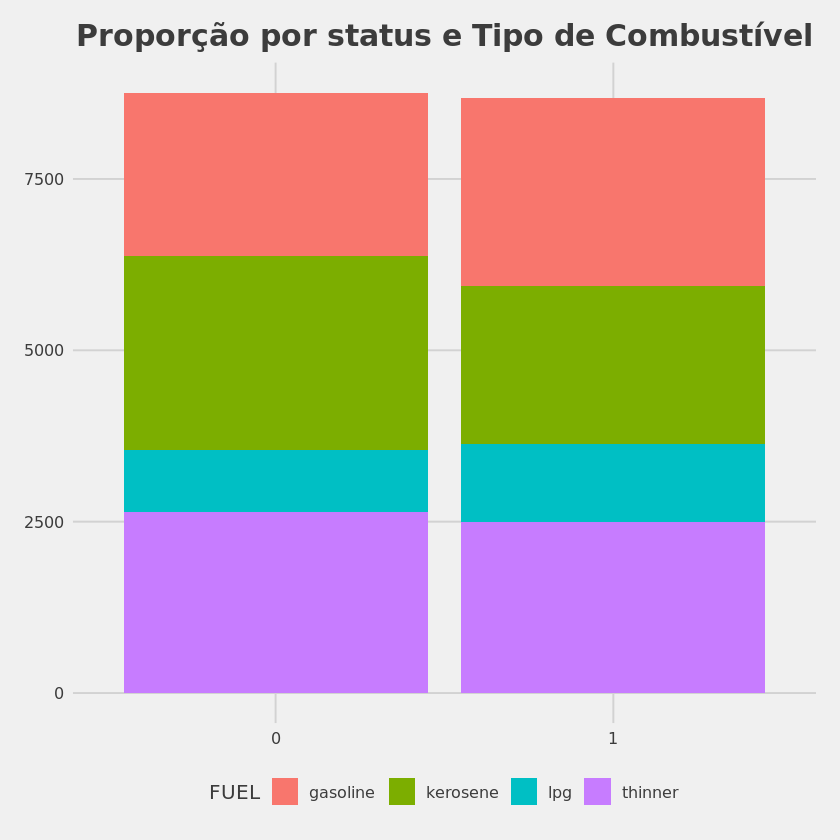

In [4]:
dados %>%
    group_by(STATUS, FUEL) %>%
    summarise(Quantidade = n()) %>%
    ggplot() +
    aes(x = STATUS, y = Quantidade, fill = FUEL) +
    geom_col() + 
    labs(x = "Status", y = "Quantidade") +
    theme_fivethirtyeight() +
    theme(
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        plot.title = element_text(
            hjust = 0.5
    )
    ) +
    labs(
        title = "Proporção por status e Tipo de Combustível"
    )

# Compreendendo as variáveis dependentes

## Distribuição de cada tipo de combustível

Como podemos observar, para o combustível de tipo lpg, a quantidade de dados é menor que as demais, logo, seria esperado que o modelo não tenha um desempenho tão bom para esse tipo de combustível que os demais.

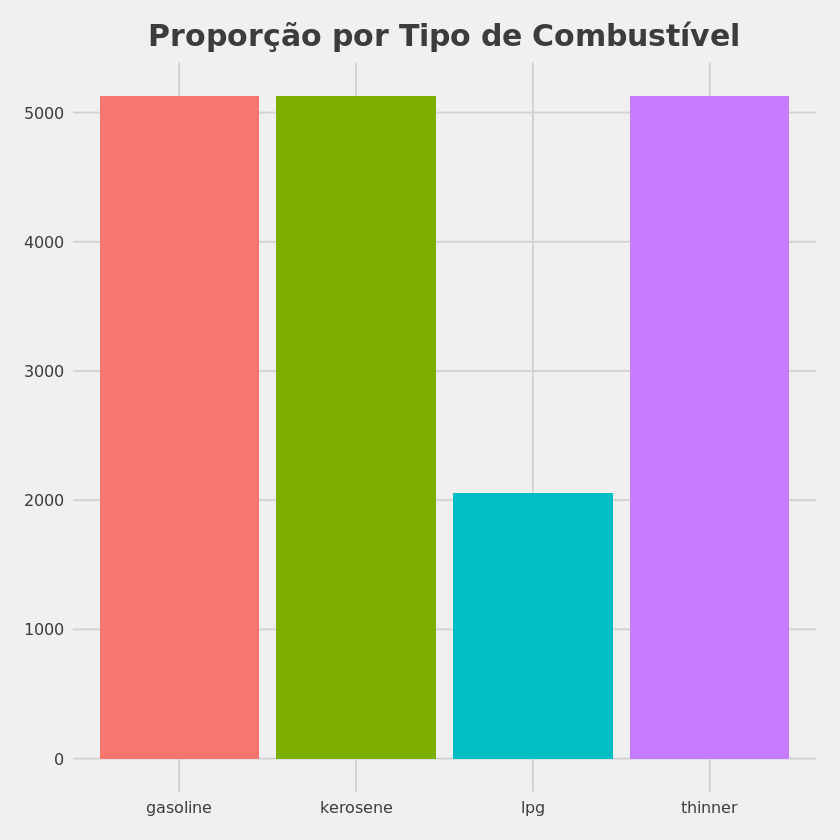

In [5]:
dados %>%
    group_by(FUEL) %>%
    summarise(Quantidade = n()) %>%
    ggplot() +
    aes(x = FUEL, y = Quantidade, fill=FUEL) +
    geom_col() +
    labs(x = "Combustível", y = "Quantidade") +
    theme_fivethirtyeight() +
    theme(
        legend.position = "none",
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        plot.title = element_text(
            hjust = 0.5
    )
    ) +
    labs(
        title = "Proporção por Tipo de Combustível"
    )


## Distribuição do Tamanho

De acordo com os metadados, o tamanho do extintor pode ser de 1 a 7. Como podemos observar no gráfico abaixo, quando o tamanho é igual a 7 ou 8 existe um sub-representação de dados isso se deve ao fato de que esse tamanho de extintor só é utilizado quando o tipo de combustível é lpg, logo, da mesma forma que concluímos acima, o modelo não terá um desempenho tão bom para esse tipo de combustível.

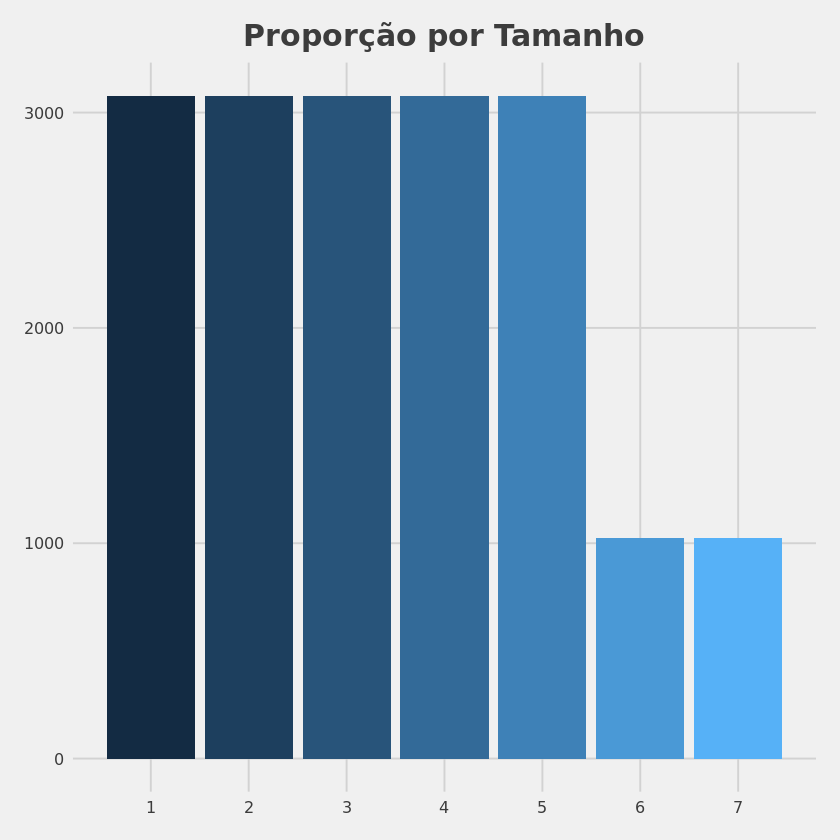

In [6]:
dados %>%   
    group_by(SIZE) %>%
    summarise(Quantidade = n()) %>%
    ggplot() +
    aes(x = SIZE, y = Quantidade, fill = SIZE) +
    geom_col() +
    theme_fivethirtyeight() +
    theme(
        legend.position = "none",
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        plot.title = element_text(
            hjust = 0.5
        )
    ) +
    labs(
        title = "Proporção por Tamanho"
    ) +
    scale_x_continuous(breaks = seq(0, 10, 1))

## Distribuição das demais colunas numéricas

Como podemos observar no gráfico abaixo, as colunas numéricas possuem uma distribuição bem diferente tanto em termos de média quanto de desvio padrão, logo, será necessário realizar algum tipo de normalização dos dados na etapa de modelagem dos dados.

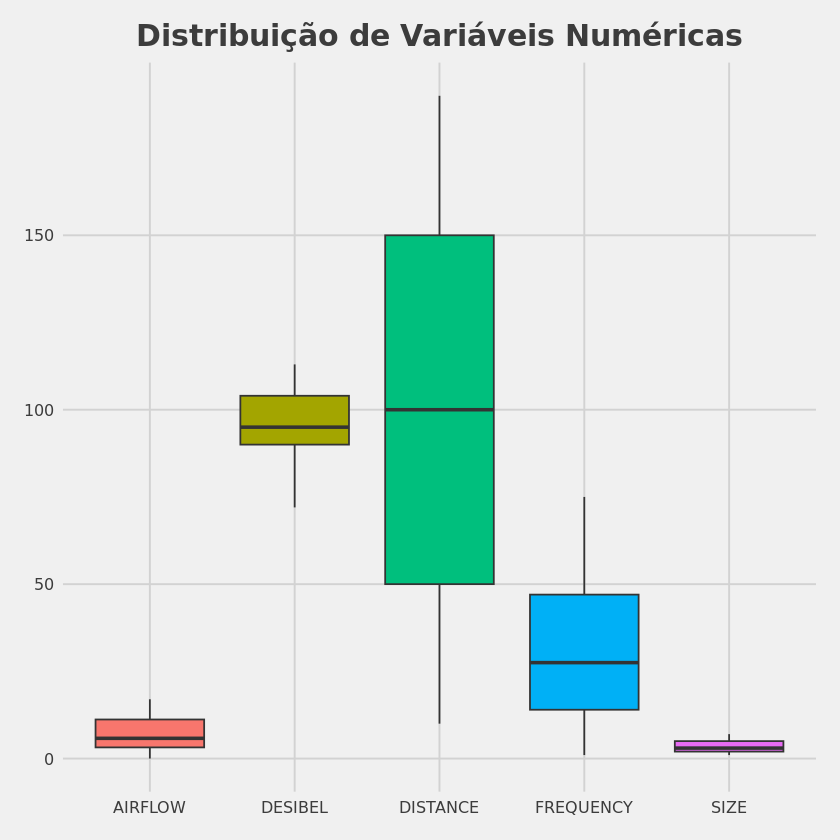

In [7]:
dados %>%
    select_if(is.numeric) %>%
    gather(key = "Variável", value = "Valor") %>%
    ggplot() +
    aes(x = Valor, y = Variável, fill = Variável) +
    geom_boxplot() +
    coord_flip() +
    theme_fivethirtyeight() +
    theme(
        legend.position = "none",
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        plot.title = element_text(
            hjust = 0.5
        )
    ) +
    labs(
        title = "Distribuição de Variáveis Numéricas"
    )